In [1]:
from Utils_Bashivan import *

In [2]:
import numpy as np

3D sensors locations on the scalp, to be converted to 2D later.

In [3]:
locs = np.load('Electroloc/Neuro_loc_DEAP.npy')

In [4]:
locs.shape

(32, 3)

In [5]:
locs[:5]

array([[-28.23010227, 102.26294022,  31.73459731],
       [-32.32332412,  97.52191223,  59.21113179],
       [-48.18205131,  76.34876907,  80.94883837],
       [-67.35513444,  62.32957061,  30.46685071],
       [-74.02481482,  42.12832367,  66.46981722]])

In [6]:
deap_path = '../../datasets/DEAP/merged/'
save_path = '../../datasets/DEAP/image_generation'

In [7]:
X = np.load(deap_path + 'deap_data.npy')
X.shape

(1280, 40, 8064)

In [8]:
y = np.load(deap_path + 'deap_full_labels.npy')
y.shape

(1280, 3)

Use only EEG channels

In [9]:
X_eeg = X[:, :32, :]

Conversion of 3D to 2D coordinates (Azimuthal Equidistant Projection)

In [10]:
n_gridpoints = 32

In [11]:
locs_2d = np.empty((locs.shape[0], 2))
locs_2d.shape

(32, 2)

In [12]:
for i, sensor_location in enumerate(locs):
    locs_2d[i] = azim_proj(sensor_location)

In [13]:
locs_2d[:5]

array([[-0.34064478,  1.23397841],
       [-0.3297067 ,  0.99475002],
       [-0.44821694,  0.71023983],
       [-0.91763312,  0.84916582],
       [-0.78925268,  0.44917225]])

For the features parameter the PSD (Power Spectral Density) of each channel must be computed. For each channel there will be N frequency bands, so the features shape will be (n_samples, n_channels * N)

https://mne.tools/stable/generated/mne.time_frequency.psd_multitaper.html

https://mne.tools/stable/generated/mne.time_frequency.psd_array_multitaper.html

https://mne.tools/stable/generated/mne.filter.resample.html

In [14]:
import mne

In [15]:
# def compute_psd(epoch, fmin=-1., fmax=60.):
#     psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=10, verbose=50)
#     return resample(psds, num=1500, axis=2)[0, :]

Compute PSD for participant 2, as an example

Final features shape should be (n_samples, n_features), where n_samples = 1280 (32 subjs * 40 trials) and n_features = 40 * X (40 channels and X frequency bands)

For each frequency band (which are 5) the paper states to compute the square sum of the frequencies involved, to get a single value. This implementation uses the average.

In [16]:
psds, freqs = mne.time_frequency.psd_array_multitaper(X_eeg[1], sfreq=128, fmin=-1., fmax=60., verbose=50)

In [17]:
# psds_resample = mne.filter.resample(psds, axis=1)

Here psd_array_multitaper computer the psds for every channel and assembled it together, later only one channel at a time will be calculated with the Welch method

In [18]:
print(psds.shape)
print(freqs.shape)

(32, 3781)
(3781,)


In [19]:
#print(*freqs, sep='\t')

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

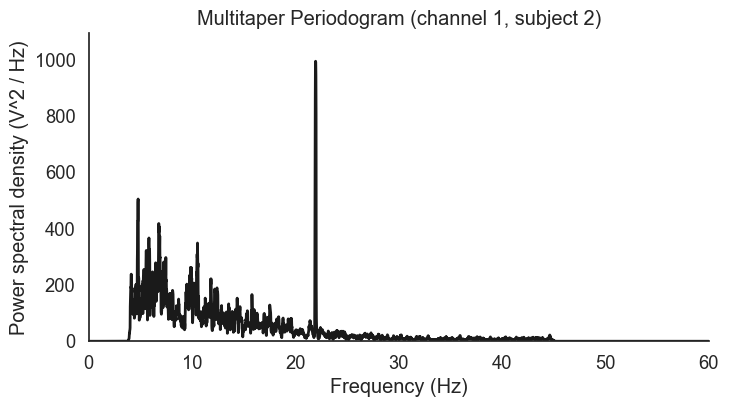

In [21]:
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psds[0], color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psds[0].max() * 1.1])
plt.title("Multitaper Periodogram (channel 1, subject 2)")
plt.xlim([0, freqs.max()])
sns.despine()

Trying Welch method for PSD

https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html

https://mne.tools/stable/generated/mne.time_frequency.psd_welch.html

https://sapienlabs.org/lab-talk/factors-that-impact-power-spectrum-density-estimation/

should n_fft be changed from 256 to 8192? (higher power of 2 number from X number of time samples, 8064). Also n_per_seg was 4*sfreq, now set equal to n_fft.

In [22]:
psds_w, freqs_w = mne.time_frequency.psd_array_welch(X_eeg[1, 0], sfreq=128, fmin=-1., fmax=60., n_fft=1024,
                                                          n_overlap=0, n_per_seg=None, average='mean', verbose=50)

In [23]:
print(psds_w.shape)
print(freqs_w.shape)

(481,)
(481,)


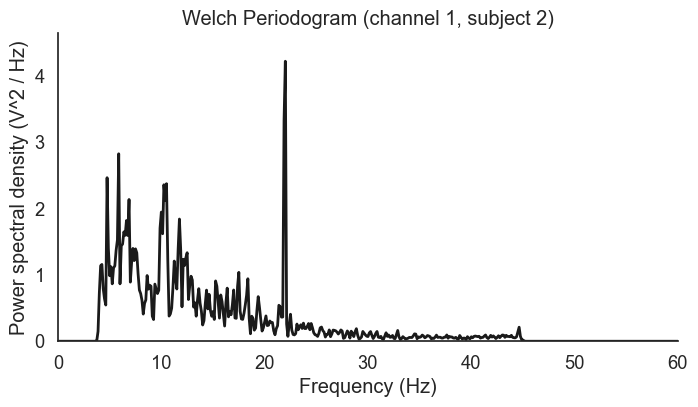

In [24]:
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs_w, psds_w, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psds_w.max() * 1.1])
plt.title("Welch Periodogram (channel 1, subject 2)")
plt.xlim([0, freqs_w.max()])
sns.despine()

In [25]:
bands = [4, 8, 10, 12, 30, 60] # 5 frequency bands: theta, slow alpha, alpha, beta, gamma (DEAP paper, Saliency too?)

# DEAP: theta (4-8 Hz), slow alpha (8-10 Hz), alpha (8-12 Hz), beta (12-30 Hz), and gamma (30-60 Hz)
# Should the number of bands be 4 and not 5? alpha and slow alpha overlap, only use alpha?

In [26]:
bands_bashivan = [4, 7, 13, 30] # 3 frequency bands: theta, alpha, beta

In [27]:
freqs_w.shape

(481,)

In [28]:
freqs_w

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125,  6.25 ,  6.375,  6.5  ,  6.625,  6.75 ,  6.875,
        7.   ,  7.125,  7.25 ,  7.375,  7.5  ,  7.625,  7.75 ,  7.875,
        8.   ,  8.125,  8.25 ,  8.375,  8.5  ,  8.625,  8.75 ,  8.875,
        9.   ,  9.125,  9.25 ,  9.375,  9.5  ,  9.625,  9.75 ,  9.875,
       10.   , 10.125, 10.25 , 10.375, 10.5  , 10.625, 10.75 , 10.875,
       11.   , 11.125, 11.25 , 11.375, 11.5  , 11.625, 11.75 , 11.875,
       12.   , 12.125, 12.25 , 12.375, 12.5  , 12.625, 12.75 , 12.875,
       13.   , 13.125, 13.25 , 13.375, 13.5  , 13.625, 13.75 , 13.875,
      

In [29]:
psds_w.shape

(481,)

In [30]:
psds_w[:5]

array([2.59233140e-04, 2.35319751e-04, 1.57500781e-05, 1.58918689e-05,
       1.60845361e-05])

In [31]:
def frequency_binning_reduction(psd, freqs, bands, reduction='mean'):
    reduced_frequencies = np.empty(len(bands) - 1)
    
    for i in range(len(bands) - 1):
        low_freq = bands[i]
        high_freq = bands[i+1]
        freq_points_counter = 0
        freq_band_sum = 0
        for j, freq in enumerate(freqs):
            if freq >= low_freq and freq < high_freq:
                freq_points_counter += 1
                freq_band_sum += psd[j]
                
        reduced_frequencies[i] = freq_band_sum / freq_points_counter
        
    
    return reduced_frequencies

In [32]:
test_reduced_psd = frequency_binning_reduction(psds_w, freqs_w, bands)
test_reduced_psd

array([1.30033631, 0.74650407, 1.33097437, 0.39936967, 0.03420834])

In [33]:
test_reduced_psd.shape

(5,)

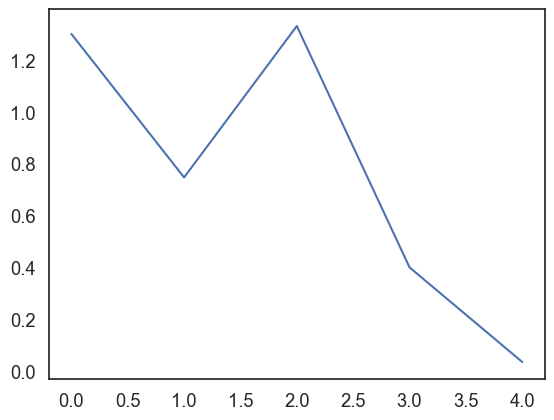

In [34]:
plt.plot(test_reduced_psd)
plt.show()

In [35]:
X_eeg.shape

(1280, 32, 8064)

In [36]:
def generate_participants_array(): # using 0-31 range as the Sal_Model.py code
    participants = np.empty((1280,))
    participant_id = 0
    
    for i in range(1280):
        if i % 40 == 0:
            participant_id += 1
        participants[i] = participant_id
    
    return participants

In [37]:
participants = generate_participants_array()
participants[:80]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

## EEG Feature Generation

https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html

https://sapienlabs.org/lab-talk/factors-that-impact-power-spectrum-density-estimation/

"Due to the way the FFT algorithm works, the convention is to set N to the power of 2 that is next above the length(x). For instance, if length(x) is 1000, then N = 1024 (2^10).  Although, this is not mandatory, it just makes for an efficient and faster implementation of FFT. However, it is recommend not to set N < length(x), because FFT will then utilize only the first N samples of the data to estimate the PSD and truncate rest of the data."

should n_fft be changed from 256 to 8192? (higher power of 2 number from X number of time samples, 8064). Also n_per_seg was 4*sfreq, now set equal to n_fft.

In [38]:
sampling_freq = 128
n_overlap = 0
n_per_seg = None # default 4 * sampling_freq
n_fft = 1024 # default 256

deap_bands = [4, 8, 10, 12, 30, 60]
n_samples = X_eeg.shape[0] # number of participants (32) * trials (40)
n_channels = X_eeg.shape[1] # 32
n_features = n_channels * (len(deap_bands) - 1) # 32 * 5 = 160

features = np.empty((n_samples, n_features)) # shape (1280, 160)

for i, subject_data in enumerate(X_eeg):
    reduced_psds = []
    psds, freqs = mne.time_frequency.psd_array_welch(subject_data, sfreq=sampling_freq, fmin=-1., fmax=60., n_fft=n_fft,
                                                     n_overlap=n_overlap, n_per_seg=n_per_seg, average='mean', verbose=50) 
    for j, psd_channel in enumerate(psds):        
        reduced_psd = frequency_binning_reduction(psd_channel, freqs, deap_bands)
        reduced_psds.append(reduced_psd)

    features[i] = np.stack(reduced_psds, axis=1).flatten()

In [39]:
features.shape

(1280, 160)

In [40]:
psds.shape

(32, 481)

In [41]:
freqs.shape

(481,)

In [42]:
features[0, :5]

array([1.00700963, 1.39128565, 1.49043889, 1.41023142, 0.75699579])

In [44]:
save_path

'../../datasets/DEAP/image_generation'

In [45]:
np.save(save_path + '/participants.npy', participants)

In [46]:
np.save(save_path + '/features.npy', features)

In [47]:
# images_timewin = 
# np.array([gen_images(np.array(locs_2d),
# feats[:, i * 192:(i + 1) * 192],
# 32,
# normalize=True) for i in range(int(feats.shape[1] / 192))])

## EEG Generate Images

```python 
def image_generation(feature_matrix, electrodes_loc, n_gridpoints) 
```

In [48]:
from Utils import *

In [49]:
print(features.shape)
print(locs_2d.shape)

(1280, 160)
(32, 2)


In [50]:
eeg_image_size = 32

In [51]:
eeg_images = image_generation(features, locs_2d, eeg_image_size)

Signals interpolations.


In [52]:
np.save(save_path + '/images.npy', eeg_images)

In [53]:
eeg_images.shape

(1280, 5, 32, 32)

In [54]:
image_test = np.moveaxis(eeg_images[0], 0 ,-1)
image_test.shape

(32, 32, 5)

In [55]:
image_test_normalized = (image_test - np.min(image_test)) / (np.max(image_test) - np.min(image_test))

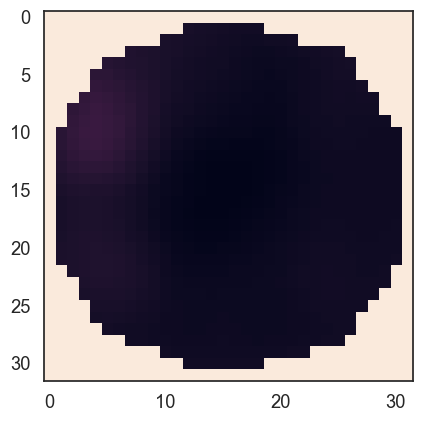

In [56]:
plt.imshow(image_test_normalized[:, :, 2]) # first participant, image of alpha band psd 
plt.show()